<a href="https://colab.research.google.com/github/Abdulhamid97Mousa/MLP_VibrationSignal_BearingFaultDiagnosis/blob/main/Multiclass_Classification_For_Bearings_Fault_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multiclass Classification For Bearing Fault Diagnosis

Bearing fault diagnosis has been a challenge in the monitoring activities of rotating machinery, and it's receiving more and more attention. The conventional fault diagnosis methods usually extract features from the waveforms or spectrums of vibration signals in order to correctly classify faults.

# 1. Introduction
This notebook shows the study of the [CWRU Bearing Dataset](https://csegroups.case.edu/bearingdatacenter/home), which contains data of normal and fault bearings. Artificial defects of different diameters (0.007 ~ 0.028 Inches) are manufactured at different locations of the bearings: inner raceway(IR), outer raceway(OR) and ball(B) defects. 

Vibration data was recorded for motor loads of 0 to 3 hp (motor speed of 1797 to 1720 RPM) using accelerometers at the drive end (DE) and fan end (FE) and the data is stored as Matlab files. The sampling rate is 12 kHz and each Matlab file contains between ~120k to ~240k sample points. For more information please refer to the [website](https://csegroups.case.edu/bearingdatacenter/home).

This study focuses on the classification of the drive end bearing defects using only the signal data at **DE**. It is a **multiclass classification** problem. The input is the vibration signal data at DE and the output is the type of defects:
- 0 : Normal (N), 
- 1 : Fault at Ball (B),
- 2 : Fault at Inner Raceway (IR), 
- 3 : Fault at Outer Raceway (OR), 



In [1]:
import errno, os
import requests
import scipy.io as sio
import numpy as np

from os import listdir
from os.path import isfile, join
from zipfile import ZipFile 
from sklearn.model_selection import train_test_split

# Pytorch
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
from torch import optim
from torch.nn.modules.loss import CrossEntropyLoss

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Download the dataset - CWRU

The dataset is downloaded from the [Github](https://github.com/Abdulhamid97Mousa/CWRU-dataset-1) repository.                                            
`I Here by admit that i haven't put the files in the correct order by myself, but instead taken the dataset already built structure from this person:` [Contact-Card](https://github.com/s-whynot).
  
The dataset has several matlab files where the name is just a number (such as "118.mat"). It has information such as
1. **State** -
     - `N` for *normal* state, not damaged
     - `B` for *ball* damage
     - `IR` for *inner raceway* damage
     - `OR` for *outer raceway* damage
2. **Fault Diameter** -
    - `007` for 0.007 inch damage
    - `014` for 0.014 inch damage 
    - `021` for 0.021 inch damage
    - `028` for 0.028 inch damage  
    the unit 'mils' is 1/1000th of an inch
3. **Position of the sensor** 
    - *3*, *6*, *12* for *outer raceway* faults located at 3 o’clock, at 6 o’clock and at 12 o’clock respectively of the load zone
4. **Load** can be:
    - *0*, *1*, *2*, *3* for different motor load conditions in Horsepower (HP)

In [3]:
print(os.getcwd())
filename = os.path.join(os.getcwd(), 'repo.zip')
print(filename)

/content
/content/repo.zip


In [4]:
filename = os.path.join(os.getcwd(), 'repo.zip')
url = 'https://github.com/Abdulhamid97Mousa/CWRU-dataset-1/archive/refs/heads/main.zip'

r = requests.get(url)
print(filename)
with open(filename, 'wb') as f:
    f.write(r.content) 

file_name = "/content/repo.zip"
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Finished Extracting!') 

/content/repo.zip
Extracting all the files now...
Finished Extracting!


# 3. Edit the downloaded data

Using the data collected at the *Drive End*, which is labeled as the code `DE`, this function picks up the time signal from a file. For the given code, a regex is made on the dictionary keys, looking for the the code and ignoring the rest of the suffix. 

The function also converts the unit to SI.

In [5]:
def acceleration_time_signal(dict_1, code):
    """
    load the time series in the file and convert units in SI
    file= 'filename' from the ./dataset/ folder
    code= ' DE' or 'FE', other code will give error
    """
    import re
    try:
        for key in dict_1:
            # print(key)
            if re.findall(rf"({code})", key):
                dict_code = key
        #inches to meter
        unit_conv = 0.0254
        x = dict_1[dict_code] * unit_conv
        return x
    except:
        print('File does not exist or code wrong. Code must be either "DE or "FE" ')

- 3 different functions are necessary to process the files and the data
- All subfolders scanned recursively with the function `fast_scandir` 

In [6]:
def Read_MAT_files_from_folders(file_path, files_list, code):
  G_data = []
  for i in range(len(files_list)):
    data = sio.loadmat(os.path.join(file_path, files_list[i]))
    sig = acceleration_time_signal(data, code)
    # print('what is signal type and sig len and signal shape', type(sig), len(sig), sig.shape)
    G_data.append(sig)
  
  G_data = np.vstack(G_data).flatten()
  # print("what is G_data", G_data)
  return G_data 

def Percent_data_split(array_1, array_2, percent_1 = 10, index_1 = False):
  if index_1 == False:
    #splitting FE data by percent 
    len_n = array_1.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])
  else:
    #splitting array_1 data by percent of array_2 data
    len_n = array_2.shape[0]
    percent_true = percent_1/100
    x = int(percent_true*len_n) #% split
    data_percent, data_rest = np.split(array_1, [x])

  return data_percent, data_rest

def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    
    return subfolders 

### 3.1 Normal Acceleration data 
CWRU DE 

In [7]:
#12k Normal Signal for DE
file_path_1 = '/content/CWRU-dataset-1-main/Normal'
onlyfiles_1 = [f for f in listdir(file_path_1) if isfile(join(file_path_1, f))]

print(onlyfiles_1)
print(type(onlyfiles_1))
print(len(onlyfiles_1))

G_data_N_DE = Read_MAT_files_from_folders(file_path_1, onlyfiles_1, "DE")
display(G_data_N_DE.shape)
print(type(G_data_N_DE))

['100_Normal_3.mat', '98_Normal_1.mat', '97_Normal_0.mat', '99_Normal_2.mat']
<class 'list'>
4


(1698547,)

<class 'numpy.ndarray'>


### 3.2 Faulty bearing data at DE: 12000 Hz DE  
`12k is the sampling rate fs` 
1. B, 
2. IR, 
3. OR

In [8]:
#12k DE data load
file_path_2 = '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data'
subfolder_path = fast_scandir(file_path_2)
print(subfolder_path)

G_data_OR_007_DE = []
G_data_OR_021_DE = []

for i in range(3, len(subfolder_path), 1):
  dir_1 = subfolder_path[i]
  # print(subfolder_path[i])
  #B
  if 'B/' in dir_1:
    onlyfiles_2_1 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_B_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '014' in dir_1:
    #014
      G_data_B_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    elif '021' in dir_1:
    #021
      G_data_B_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
    else:
    #028
      G_data_B_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_1, "DE")
  #B
  #IR
  elif 'IR/' in dir_1:
    onlyfiles_2_2 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]

    if '007' in dir_1:
    #007
      G_data_IR_007_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '014' in dir_1:
    #014
      G_data_IR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    elif '021' in dir_1:
    #021
      G_data_IR_021_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
    else:
    #028
      G_data_IR_028_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_2, "DE")
  #IR
  #OR
  elif 'OR/' in dir_1:
    onlyfiles_2_3 = [f for f in listdir(dir_1) if isfile(join(dir_1, f))]
    if '007' in dir_1:
      #007
      for i in range(len(onlyfiles_2_3)):
        data_OR_007 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_007 = acceleration_time_signal(data_OR_007, code='DE')
        G_data_OR_007_DE.append(or_sig_007)
    elif '014' in dir_1:
      #014
      G_data_OR_014_DE = Read_MAT_files_from_folders(dir_1, onlyfiles_2_3, "DE")
    else:
      #021
      for i in range(len(onlyfiles_2_3)):
        data_OR_021 = sio.loadmat(os.path.join(dir_1, onlyfiles_2_3[i]))
        or_sig_021 = acceleration_time_signal(data_OR_021, code='DE')
        G_data_OR_021_DE.append(or_sig_021)
  #OR 
print("G_data_B_007_DE", G_data_B_007_DE.shape)
print("G_data_B_014_DE", G_data_B_014_DE.shape)
print("G_data_B_021_DE", G_data_B_021_DE.shape)
print("G_data_B_028_DE", G_data_B_028_DE.shape)
G_data_B_DE = np.concatenate((G_data_B_007_DE, G_data_B_014_DE, G_data_B_021_DE), axis=0).flatten()
print("G_data_B_DE", G_data_B_DE.shape)
print("G_data_B_DE type", type(G_data_B_DE))

print("G_data_IR_007_DE", G_data_IR_007_DE.shape)
print("G_data_IR_014_DE", G_data_IR_014_DE.shape)
print("G_data_IR_021_DE", G_data_IR_021_DE.shape)
print("G_data_IR_028_DE", G_data_IR_028_DE.shape)
G_data_IR_DE = np.concatenate((G_data_IR_007_DE, G_data_IR_014_DE, G_data_IR_021_DE), axis=0).flatten()
print("G_data_IR_DE", G_data_IR_DE.shape)

G_data_OR_007_DE = np.vstack(G_data_OR_007_DE).flatten()
print("G_data_OR_007_DE", G_data_OR_007_DE.shape)
G_data_OR_014_DE = np.vstack(G_data_OR_014_DE).flatten()
print("G_data_OR_014_DE", np.shape(G_data_OR_014_DE))
G_data_OR_021_DE = np.vstack(G_data_OR_021_DE).flatten()
print("G_data_OR_021_DE", G_data_OR_021_DE.shape)
G_data_OR_DE = np.concatenate((G_data_OR_007_DE, G_data_OR_014_DE, G_data_OR_021_DE), axis=0).flatten()
print("G_data_OR_DE", np.shape(G_data_OR_DE))      

['/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/IR', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/B', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/IR/007', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/IR/014', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/IR/028', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/IR/021', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/B/007', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/B/014', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/B/028', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/B/021', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/007', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/014', '/content/CWRU-dataset-1-main/12k_Drive_End_Bearing_Fault_Data/OR/021', '/conten

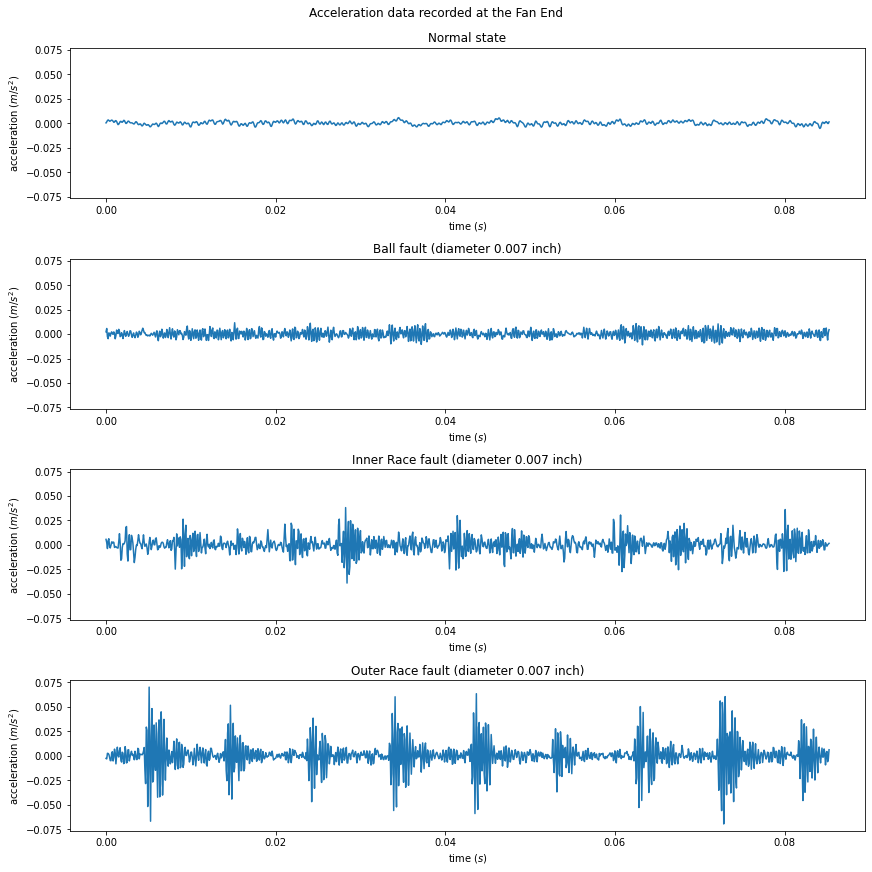

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

range_of_samples = np.arange(0,1024)
fs = 12000

# plotting
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12, 12), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Fan End')

axs[0].plot(range_of_samples/fs, G_data_N_DE[range_of_samples])
axs[0].set_title('Normal state')

axs[1].plot(range_of_samples/fs, G_data_B_007_DE[range_of_samples])
axs[1].set_title('Ball fault (diameter 0.007 inch)')

axs[2].plot(range_of_samples/fs, G_data_IR_007_DE[range_of_samples])
axs[2].set_title('Inner Race fault (diameter 0.007 inch)')

axs[3].plot(range_of_samples/fs, G_data_OR_007_DE[range_of_samples])
axs[3].set_title('Outer Race fault (diameter 0.007 inch)')

for ax in axs.flat:
    ax.set(xlabel='time $(s)$', ylabel='acceleration $(m/s^2)$')

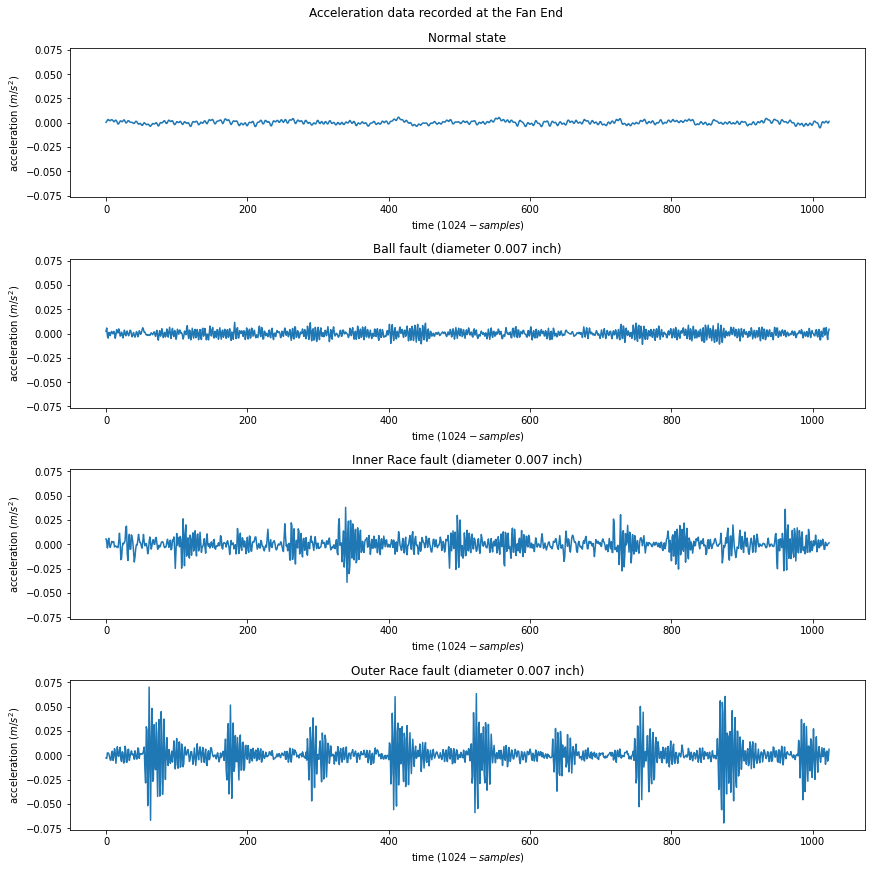

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

range_of_samples = np.arange(0,1024)
fs = 12000

# plotting
fig, axs = plt.subplots(4, 1, sharey=True, figsize=(12, 12), constrained_layout=True)
fig.suptitle('Acceleration data recorded at the Fan End')

axs[0].plot(G_data_N_DE[range_of_samples])
axs[0].set_title('Normal state')

axs[1].plot(G_data_B_007_DE[range_of_samples])
axs[1].set_title('Ball fault (diameter 0.007 inch)')

axs[2].plot(G_data_IR_007_DE[range_of_samples])
axs[2].set_title('Inner Race fault (diameter 0.007 inch)')

axs[3].plot(G_data_OR_007_DE[range_of_samples])
axs[3].set_title('Outer Race fault (diameter 0.007 inch)')

for ax in axs.flat:
    ax.set(xlabel='time $(1024-samples)$', ylabel='acceleration $(m/s^2)$')

## 4. Architecture of the CNN
As the picture in our blogpost shows , we can distinguish 3 main conceptual phases.

1. Data chunking
2. Data labeling `give the data a label 0,1,2 and 3`
2. Data shuffling
3. Convolutional Neural Network

### 4.1. Data chunking
We'll divide the signal in chunks of size `chunk_size`, and take a subset `number_of_chunks` from all the available for training and testing the CNN. A chunk is simply a sequential subset of the time series data with a fixed length - the `chunk_size`. Every chunk is distinct - there are no overlapping samples in different chunks. This method is said tumbling time windowing, for more info you can see this [blog post](https://blog.codecentric.de/en/2018/10/window-functions-in-stream-analytics/). Each time series is an array, and they have slight difference in length. This means that if we fix a chunk size to divide the file, we need a function to split the data exaclty in `number_of_chunks` of `chunk_size` and get rid of the remaining part. We can write a function for that, `split_exact`, which takes the array to be splitted, the number of chunks and the array axis to be splitted.

In [11]:
def split_exact(x, n_chunks=2, axis=1):

    # L = Length of x
    l = np.shape(x)[axis]
    print("length of x: ", l)

    # x_split = x
    x_split = x
    if l > n_chunks > 1:
        n = n_chunks
        print("number of chunks is :", n)
        if axis == 0:
            # x_split returns list of ndarrays A list of sub-arrays
            x_split = np.split(x[:-(l % n)], n, axis=axis)
            print("number of sub arrays: ", len(x_split))
        elif axis == 1:
            x_split = np.split(x[:, :-(l % n)], n,  axis=axis)
    return x_split

Some operations were performed on the data. 

For the CWRU Data only - ignoring the 0.028 inch fault diameter from `IR` and `B`, only considering the rest:

* the **normal** data labelled as `N` - Baseline

* the **inner raceway** data labelled as `IR`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter
* the **ball** data labelled as `B`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter
* the **outer raceway** data labelled as `OR`
      1.for 0.007 inch fault diameter
      2.for 0.014 inch fault diameter
      3.for 0.021 inch fault diameter

For every load, the data is joined from `0...3` HP load, normalizing it with respect to the *standard deviation*. This is because the load is not considered in *Classification*. 

Several functions needed, such as; `load_raw_matlab_data` which returns several multidimensional arrays for `N`, `IR`, `B` and `OR` data with dimension of the maximum `number_of_chunks` obtainable from the data, by `chunk_size`. 

In [12]:
def g_data_chunkSplit(gdata, chunk_size=128):
    """
    Change loaded mat files and splits it in chunks of size chunk_size
    """
    y_n: ndarray = np.array([])
    # signal
    x = gdata
    x = x / np.std(x)
    y_n = np.append(y_n, x)
    n_splits = len(y_n) // chunk_size
    y_n = split_exact(y_n, n_chunks=n_splits, axis=0)

    return y_n

Initializing the data using the latter function.

### 4.1.1 Source Domain data chunk



In [13]:
chunk_size_1 = 1200


#DE data
normal_data_chunk_DE = g_data_chunkSplit(G_data_N_DE, chunk_size=chunk_size_1)
display("DE")
print("normal_data_chunk_DE", np.shape(normal_data_chunk_DE))
print("type normal_data_chunk_DE", type(normal_data_chunk_DE))
print("---------------")
b_data_chunk_DE = g_data_chunkSplit(G_data_B_DE, chunk_size=chunk_size_1)
print("ball_data_chunk_DE", np.shape(b_data_chunk_DE))
print("---------------")
ir_data_chunk_DE = g_data_chunkSplit(G_data_IR_DE, chunk_size=chunk_size_1)
print("ir_data_chunk_DE", np.shape(ir_data_chunk_DE))
print("---------------")
or_data_chunk_DE = g_data_chunkSplit(G_data_OR_DE, chunk_size=chunk_size_1)
print("or_data_chunk_DE", np.shape(or_data_chunk_DE)) 

length of x:  1698547
number of chunks is : 1415
number of sub arrays:  1415


'DE'

normal_data_chunk_DE (1415, 1200)
type normal_data_chunk_DE <class 'list'>
---------------
length of x:  1463166
number of chunks is : 1219
number of sub arrays:  1219
ball_data_chunk_DE (1219, 1200)
---------------
length of x:  1463077
number of chunks is : 1219
number of sub arrays:  1219
ir_data_chunk_DE (1219, 1200)
---------------
length of x:  3418357
number of chunks is : 2848
number of sub arrays:  2848
or_data_chunk_DE (2848, 1200)


### 4.2 Data labeling 
`give the data a label 0,1,2 and 3`

This study focuses on the classification of the drive end bearing defects using only the signal data at **DE**. It is a **multiclass classification** problem. The input is the vibration signal data at DE and the output is the type of defects:

`- 0 : Normal (N), `

`- 1 : Fault at Ball (B),`

`- 2 : Fault at Inner Raceway (IR), `

`- 3 : Fault at Outer Raceway (OR), `


In [14]:
d_n = (1415, 1)
y_noraml = np.zeros(d_n, dtype=int)
print("label 0 for normal data ", y_noraml.shape)
print(type(y_noraml))

d_b = (1219, 1)
y_ball = np.ones(d_b, dtype=int)
print("label 1 for faulty ball bearing data ", y_ball.shape)
print(type(y_ball))

d_ir = (1219, 1)
y_ir = np.ones(d_ir, dtype=int) * 2
print("label 2 for faulty inner raceway data ", y_ir.shape)
print(type(y_ir))

d_or = (2848, 1)
y_or = np.ones(d_or, dtype=int) * 3
print("label 3 for faulty outer raceway data ", y_or.shape)
print(type(y_or))
print('----------------------------------------')

print("label 0 for normal data: ", y_noraml[0][0])
print("label 1 for faulty ball bearing data: ", y_ball[0][0])
print("label 2 for faulty inner raceway data: ", y_ir[0][0])
print("label 3 for faulty outer raceway data: ", y_or[0][0])
print("label 3 for faulty outer raceway data: ", y_or[0][0])

label 0 for normal data  (1415, 1)
<class 'numpy.ndarray'>
label 1 for faulty ball bearing data  (1219, 1)
<class 'numpy.ndarray'>
label 2 for faulty inner raceway data  (1219, 1)
<class 'numpy.ndarray'>
label 3 for faulty outer raceway data  (2848, 1)
<class 'numpy.ndarray'>
----------------------------------------
label 0 for normal data:  0
label 1 for faulty ball bearing data:  1
label 2 for faulty inner raceway data:  2
label 3 for faulty outer raceway data:  3
label 3 for faulty outer raceway data:  3


In [15]:
# convert a list to numpy array 
normal = np.array(normal_data_chunk_DE)
ball = np.array(b_data_chunk_DE)
inner_race = np.array(ir_data_chunk_DE)
outer_race = np.array(or_data_chunk_DE)

# convert numpy array to torch tensor
normal = torch.from_numpy(normal)
ball = torch.from_numpy(ball)
inner_race = torch.from_numpy(inner_race)
outer_race = torch.from_numpy(outer_race)
print(type(normal))

# covert the label data to torch tensor
y_n = torch.from_numpy(y_noraml)
y_b = torch.from_numpy(y_ball)
y_inner_r = torch.from_numpy(y_ir)
y_out_r = torch.from_numpy(y_or)


# concatenate the data of normal, ball, inner_race, outer_race
X = torch.cat((normal, ball, inner_race, outer_race), dim=0)
print(X.shape)

# concatenate the label data of normal, ball, inner_race, outer_race
y = torch.cat((y_n, y_b, y_inner_r, y_out_r), dim=0)
print(y.shape)

<class 'torch.Tensor'>
torch.Size([6701, 1200])
torch.Size([6701, 1])


In [16]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import math

In [17]:
# train_ds = TensorDataset(inputs, targets)
train_ds = TensorDataset(X, y)

In [18]:
# # Uncomment this to check
# for x_features, y_targets in train_ds:
#     print(x_features)
#     print(y_targets)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
# set aside 20% of train and test data for evaluation
train = X
test = y
print(train.shape)
print(test.shape)



X_train, X_test, y_train, y_test = train_test_split(train, test,
    test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2


print("X_train shape: {}, dtype: {}".format(X_train.shape, type(X_train)))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(X_val.shape))
print("y_val shape: {}".format(y_val.shape))

torch.Size([6701, 1200])
torch.Size([6701, 1])
X_train shape: torch.Size([4020, 1200]), dtype: <class 'torch.Tensor'>
X_test shape: torch.Size([1341, 1200])
y_train shape: torch.Size([4020, 1])
y_test shape: torch.Size([1341, 1])
X_val shape: torch.Size([1340, 1200])
y_val shape: torch.Size([1340, 1])


In [21]:
from torch.utils.data import Dataset
import torch

In [25]:
# Functions for training
def get_dataloader(train_ds, valid_ds, bs):
    '''
        Get dataloaders of the training and validation set.
        Parameter:
            train_ds: Dataset
                Training set
            valid_ds: Dataset
                Validation set
            bs: Int
                Batch size
        
        Return:
            (train_dl, valid_dl): Tuple of DataLoader
                Dataloaders of training and validation set.
    '''
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [ ]:
## Create DataLoader of train and validation set
X_train = torch.tensor(X_train, dtype=torch.float32)
X_valid = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_valid = torch.tensor(y_val, dtype=torch.long)

train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)


train_dl, valid_dl = get_dataloader(train_ds, valid_ds, 128) 


# Training with Adams Optimizer

In [ ]:
import nn_model
import helper

In [ ]:
## Instantiate model, optimizer and loss function
model = nn_model.CNN_1D_2L(len(features))
model.to(device)
opt = optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=wd)
loss_func = CrossEntropyLoss()